In [1]:
from astropy.io import fits
from tqdm import tqdm
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from censai.data.cosmos.decode_cosmos import decode_image, preprocess_image, decode_shape
import tensorflow as tf
from censai import PhysicalModelv2
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import Planck18 as cosmo


In [2]:
# datapath = os.path.join(os.getenv("CENSAI_PATH"), "data", "hkappa158_TNG100_512")
datapath = os.path.join(os.getenv("CENSAI_PATH"), "data", "hkappa188hst_TNG100_rau2_temp")

kappa = []
kappa_id = []
kappa_var = []
alpha_var = []
headers = []
i = 0
for path in tqdm(glob.glob(os.path.join(datapath, "*.fits"))):
    file = fits.open(path)
    headers.append(file["PRIMARY"].header)
    kappa.append(file["PRIMARY"].data)
    kappa_id.append(file["PRIMARY"].header["SUBID"])
    kappa_var.append(file[1].data)
    alpha_var.append(file[2].data)
    i += 1
    if i == 200:
        break


100%|██████████| 99/99 [00:00<00:00, 128.91it/s]


In [3]:
datapath = os.getenv("CENSAI_PATH") + "/data/cosmos_23.5_finalrun128_train"

files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE).map(decode_image).map(preprocess_image)
images = []
i = 0
for example in tqdm(dataset):
    i += 1
    if i <= 1000:
        images.append(example)
    if i == 1000:
        break

999it [00:00, 2186.34it/s]


In [4]:
phys = PhysicalModelv2(pixels=188, src_pixels=128, kappa_pixels=188, image_fov=10.13, src_fov=3)
psf_fwhm = 0.1
cutout_size = 20
psf = phys.psf_models(psf_fwhm, cutout_size)
plt.imshow(psf[0, ..., 0])

TypeError: 'float' object is not subscriptable

In [26]:
10.13/188

0.05388297872340426

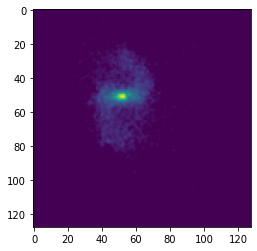

In [27]:
source = gaussian_filter(images[1][..., 0], 0)
plt.imshow(source)

In [28]:
source.sum() / 3**2

24.47036573621962

In [33]:
noise_rms = 0.05
alpha_transform = lambda x: x / cosmo.angular_diameter_distance(0.5).value * 3600 / np.pi * 180 * cosmo.h * phys.pixels / phys.image_fov

i = 1
k = kappa[i]
k_var = kappa_var[i]
a_var = alpha_var[i]
ax, ay = np.split(a_var, 2, axis=-1)
ax = alpha_transform(np.sqrt(ax[..., 0]))
ay = alpha_transform(np.sqrt(ay[..., 0]))

lens = phys.noisy_forward(source[None, ..., None], k[None, ..., None], np.array(noise_rms), psf)[0, ..., 0]

sx, sy = np.gradient(source)
print(sx.max(), sy.max())
sx = phys.forward(sx[None, ..., None], k[None, ..., None], psf)[0, ..., 0].numpy()
sy = phys.forward(sy[None, ..., None], k[None, ..., None], psf)[0, ..., 0].numpy()
print(sx.max(), sy.max())

lens_noise = np.sqrt((ax * sx)**2 + (ay * sy)**2 + noise_rms**2)

0.25457767 0.13012949
0.21405946 0.106198154


Text(0.5, 0.98, 'noise rms = 5.0e-02, PSF FWHM vs pixel=1.9')

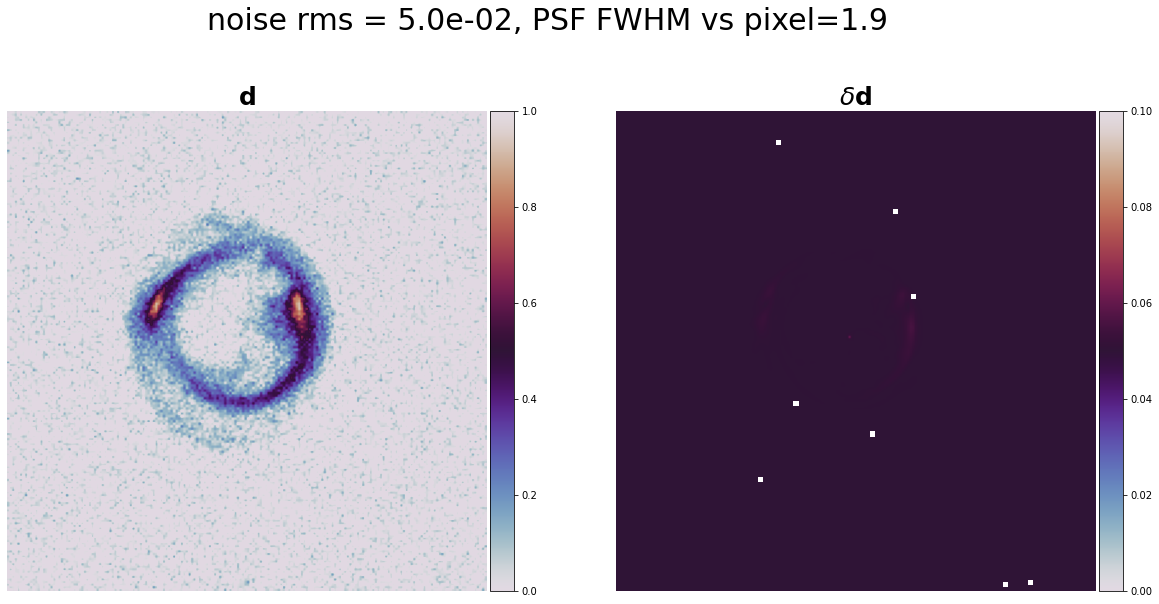

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
im = ax1.imshow(lens, cmap="twilight", vmin=0, vmax=1)
ax1.axis("off")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax2.imshow(lens_noise, cmap="twilight", vmin=0, vmax=0.1)
ax2.axis("off")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax1.set_title(r"$\mathbf{d}$", fontsize=25)
ax2.set_title(r"$\delta \mathbf{d}$", fontsize=25);
fig.suptitle(fr"noise rms = {noise_rms:.1e}, PSF FWHM vs pixel={psf_fwhm * phys.pixels / phys.image_fov:.1f}", fontsize=30)

In [ ]:


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(32, 8))
k = 13
im = ax1.imshow(kappa[k], cmap="twilight", norm=LogNorm())
ax1.axis("off")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax2.imshow(np.sqrt(kappa_var[k])/kappa[k] * 100, cmap="inferno")
ax2.axis("off")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax3.imshow(alpha_transform(np.sqrt(alpha_var[k][..., 0])), cmap="inferno", norm=LogNorm())
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax4.imshow(alpha_transform(np.sqrt(alpha_var[k][..., 1])), cmap="inferno", norm=LogNorm())
ax4.axis("off")
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)